In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, recall_score, precision_recall_curve
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [98]:
df = pd.read_csv("Bank_Transaction_Fraud_Detection.csv")

drop_cols = [
    'Customer_ID', 'Customer_Name', 'Transaction_ID', 'Merchant_ID',
    'Customer_Contact', 'Customer_Email', 'Transaction_Date', 'Transaction_Time',
    'Transaction_Location', 'Transaction_Description'
]
df = df.drop(columns=drop_cols)

df.head()

,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_Amount,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Device_Type,Is_Fraud,Transaction_Currency
0,Male,60,Kerala,Thiruvananthapuram,Thiruvananthapuram Branch,Savings,32415.45,Transfer,Restaurant,74557.27,Voice Assistant,POS,0,INR
1,Female,51,Maharashtra,Nashik,Nashik Branch,Business,43622.60,Bill Payment,Restaurant,74622.66,POS Mobile Device,Desktop,0,INR
2,Male,20,Bihar,Bhagalpur,Bhagalpur Branch,Savings,63062.56,Bill Payment,Groceries,66817.99,ATM,Desktop,0,INR
3,Female,57,Tamil Nadu,Chennai,Chennai Branch,Business,14000.72,Debit,Entertainment,58177.08,POS Mobile App,Mobile,0,INR
4,Female,43,Punjab,Amritsar,Amritsar Branch,Savings,18335.16,Transfer,Entertainment,16108.56,Virtual Card,Mobile,0,INR


In [99]:
print("Variabel Types: \n", df.dtypes)

Variabel Types: 
 Gender                   object
Age                       int64
State                    object
City                     object
Bank_Branch              object
Account_Type             object
Transaction_Amount      float64
Transaction_Type         object
Merchant_Category        object
Account_Balance         float64
Transaction_Device       object
Device_Type              object
Is_Fraud                  int64
Transaction_Currency     object
dtype: object


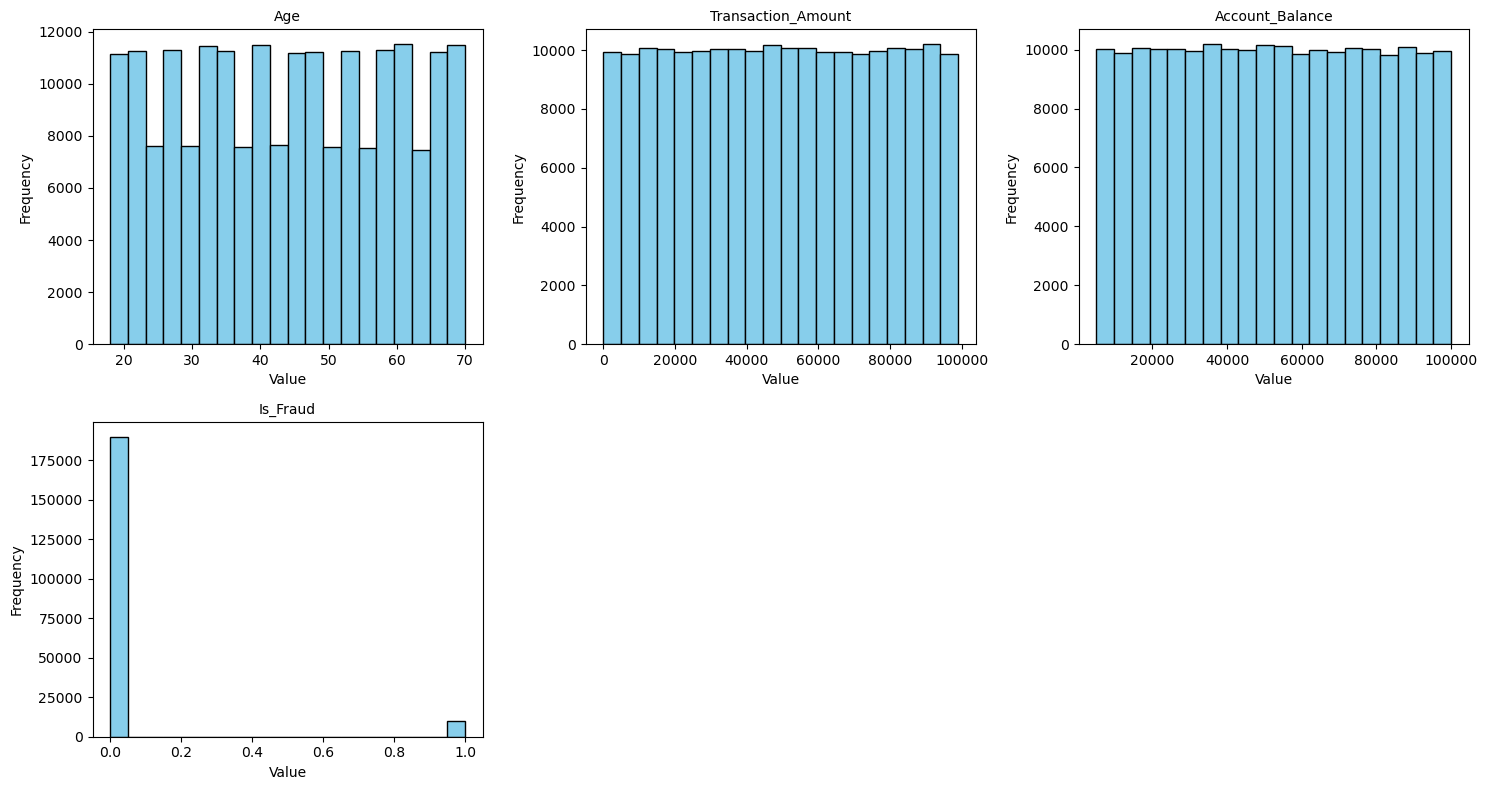

In [100]:
df_numeric = df.select_dtypes(include='number')
n_vars = df_numeric.shape[1]
n_cols = 3
n_rows = math.ceil(n_vars / n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 4))
for i in range(n_vars):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(df_numeric.iloc[:, i], bins=20, color='skyblue', edgecolor='black')
    plt.title(df_numeric.columns[i], fontsize=10)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [101]:
X = df.drop(columns=['Is_Fraud'])
y = df['Is_Fraud']

In [102]:
print("Missing Value:\n", df.isnull().sum())

Missing Value:
 Gender                  0
Age                     0
State                   0
City                    0
Bank_Branch             0
Account_Type            0
Transaction_Amount      0
Transaction_Type        0
Merchant_Category       0
Account_Balance         0
Transaction_Device      0
Device_Type             0
Is_Fraud                0
Transaction_Currency    0
dtype: int64


In [103]:
for col in X.select_dtypes(include='object').columns:
    print(f"{col}: {X[col].nunique()} unique values")

Gender: 2 unique values
State: 34 unique values
City: 145 unique values
Bank_Branch: 145 unique values
Account_Type: 3 unique values
Transaction_Type: 5 unique values
Merchant_Category: 6 unique values
Transaction_Device: 20 unique values
Device_Type: 4 unique values
Transaction_Currency: 1 unique values


In [104]:
print(df['Gender'].value_counts())
print("\n", df['Account_Type'].value_counts())
print("\n", df['Transaction_Type'].value_counts())
print("\n", df['Merchant_Category'].value_counts())
print("\n", df['Device_Type'].value_counts())
print("\n", df['Is_Fraud'].value_counts())

Gender
Male      100452
Female     99548
Name: count, dtype: int64

 Account_Type
Checking    66924
Savings     66593
Business    66483
Name: count, dtype: int64

 Transaction_Type
Credit          40180
Debit           40050
Bill Payment    40040
Transfer        39953
Withdrawal      39777
Name: count, dtype: int64

 Merchant_Category
Restaurant       33525
Entertainment    33421
Electronics      33409
Clothing         33340
Groceries        33187
Health           33118
Name: count, dtype: int64

 Device_Type
POS        50111
ATM        50055
Mobile     49962
Desktop    49872
Name: count, dtype: int64

 Is_Fraud
0    189912
1     10088
Name: count, dtype: int64


In [105]:
X['Gender'] = X['Gender'].map({'Male': 1, 'Female': 0})

In [106]:
cat_cols = ['Account_Type', 'Transaction_Type', 'Merchant_Category', 'Device_Type']
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = ohe.fit_transform(X[cat_cols])
encoded_cols = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(cat_cols), index=X.index)

X_numeric = X.drop(columns=cat_cols)
X_final = pd.concat([X_numeric, encoded_cols], axis=1)
drop_object_cols = ['State', 'City', 'Bank_Branch', 'Transaction_Device', 'Transaction_Currency']
X_final_clean = X_final.drop(columns=drop_object_cols)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final_clean, y, test_size=0.2, random_state=42, stratify=y
)

In [108]:
print("Class distribution before SMOTE:")
print(y_train.value_counts())

# Karena data Y tidak seimbang, gunakan SMOTE untuk menyeimbangkan
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Tampilkan distribusi kelas setelah SMOTE
print("Class distribution after SMOTE:")
print(y_res.value_counts())

Class distribution before SMOTE:
Is_Fraud
0    151930
1      8070
Name: count, dtype: int64
Class distribution after SMOTE:
Is_Fraud
0    151930
1    151930
Name: count, dtype: int64


In [109]:
X_train, X_val, y_train, y_val = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42, stratify=y_res
)

In [ ]:
params = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [1, 2, 5, 10],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
search = RandomizedSearchCV(xgb, params, n_iter=10, scoring='recall', cv=3, verbose=1, n_jobs=1)
search.fit(X_train, y_train)

model = search.best_estimator_
y_proba = model.predict_proba(X_val)[:, 1]

prec, rec, thresholds = precision_recall_curve(y_val, y_proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
optimal_idx = np.argmax(f1)
optimal_threshold = thresholds[optimal_idx]

y_pred_opt = (y_proba >= optimal_threshold).astype(int)

print('Best XGBoost params:', search.best_params_)
print('Optimal threshold:', optimal_threshold)
print('Classification Report:\n', classification_report(y_val, y_pred_opt))
print('Confusion Matrix:\n', confusion_matrix(y_val, y_pred_opt))
print('ROC AUC Score:', roc_auc_score(y_val, y_proba))
print('Recall (fraud class):', recall_score(y_val, y_pred_opt))
print('Accuracy:', accuracy_score(y_val, y_pred_opt))

model.save_model("fraud_detection_model.json")

print("XGBoost model saved to fraud_detection_model.json")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best XGBoost params: {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1}
Optimal threshold: 0.7847141
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     45579
           1       1.00      0.94      0.97     45579

    accuracy                           0.97     91158
   macro avg       0.97      0.97      0.97     91158
weighted avg       0.97      0.97      0.97     91158

Confusion Matrix:
 [[45579     0]
 [ 2868 42711]]
ROC AUC Score: 0.971545098357661
Recall (fraud class): 0.9370762851313105
Accuracy: 0.9685381425656553


In [ ]:
joblib.dump(ohe, 'onehot_encoder.pkl')

joblib.dump(X_final_clean.columns.tolist(), 'feature_columns.pkl')